In [1]:
import numpy as np
import torch
import torch.nn as nn
import pickle

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from torch.autograd import Variable
from pdf_mog import *
from util import train_sgd


from tqdm import tqdm_notebook as tqdm

import delfi.distribution as dd

from delfi.utils.viz import probs2contours
%matplotlib inline

In [2]:
example = pickle.load(open('example_6d.pkl', 'rb'))

In [3]:
example

{'comment': 'posterior is (uncorrected * prior) / proposal',
 'posterior': <delfi.distribution.mixture.GaussianMixture.MoG at 0x7f6a3c17a908>,
 'prior': <delfi.distribution.Gaussian.Gaussian at 0x7f69dcc7b358>,
 'proposal': <delfi.distribution.Gaussian.Gaussian at 0x7f69dcc7bc50>,
 'uncorrected': <delfi.distribution.mixture.GaussianMixture.MoG at 0x7f69dcc7b668>}

In [4]:
dtype = torch.FloatTensor

class MoG(nn.Module):
    def __init__(self, n_components, dim):
        super().__init__()

        self.n_components = n_components
        self.dim = dim
        
        self.softmax = nn.Softmax(dim=0)
        
        self.weights = nn.Parameter(
            torch.ones(n_components).type(dtype))
        self.mus = nn.Parameter(
            torch.Tensor(n_components, dim).normal_().type(dtype))
        self.Lvecs = nn.Parameter(
            torch.Tensor(int(n_components*((dim**2+dim)/2))).uniform_(0, 0.1).type(dtype))
    
    def eval(self, X):
        if type(X) == np.ndarray:
            X = torch.from_numpy(X)
        X = Variable(X.type(dtype), requires_grad=False)
        
        # weights
        weights = self.softmax(self.weights)
                
        Ls = self.get_Ls()

        lprobs = multivariate_mog_pdf(X, weights, self.mus, Ls, log=True)
        
        return lprobs, (weights, self.mus, Ls)
        
    def get_Ls(self):
        # covariance factors
        Ls = Variable(torch.zeros(self.n_components, self.dim, self.dim)).type(dtype)
        
        # assign vector to lower triangle of Ls
        (idx1, idx2) = np.tril_indices(self.dim)
        Ls[:, idx1, idx2] = self.Lvecs

        # apply exponential to get positive diagonal
        (idx1, idx2) = np.diag_indices(self.dim)
        Ls[:, idx1, idx2] = torch.exp(Ls[:, idx1, idx2])
        
        return Ls
        
    def forward(self, X):
        lprobs, (weights, self.mus, Ls) = self.eval(X)
        return -torch.mean(lprobs), (weights, self.mus, Ls)
    
    def convert_to_distribution(self):
        a = self.weights.data.numpy()
        ms = self.mus.data.numpy()
        Ls = self.get_Ls().data.numpy()
        
        Ls = np.linalg.inv(Ls)
        
        return dd.MoG(a=a, ms=ms, Us=Ls)

In [5]:
prior = example['prior']
proposal = example['proposal']
uncorrected = example['uncorrected']
post = example['posterior']

In [6]:
def fit_mog(pprior, prior, qphi, nsamples=10000, nsteps=1000, lr=0.02, es_rounds=20, es_thresh=0.0001):
    mog = MoG(n_components = 1, dim=len(prior.m))
    samples = pprior.gen(n_samples=nsamples)
                         
    llsamples_pr = prior.eval(samples, log=True)
    llsamples_ppr = pprior.eval(samples, log=True)
    llsamples_qphi = qphi.eval(samples, log=True)
    
    logterm_fixed = torch.from_numpy(llsamples_ppr - llsamples_pr - llsamples_qphi)
    logterm_fixed = Variable(logterm_fixed, requires_grad=False)
    
    optim = torch.optim.Adam(mog.parameters(), lr=lr)
    

    progress = tqdm(range(nsteps))
    
    losses = []
    
    for step in progress:
        optim.zero_grad()
        
        llsamples_pb = mog.eval(samples)[0]                 
        logterm = llsamples_pb + logterm_fixed.type(dtype)
                         
        lsamples_pb = torch.exp(llsamples_pb)
        Z_beta = torch.mean(lsamples_pb)

        eterm = torch.dot(lsamples_pb, logterm) / nsamples

        loss = -torch.log(Z_beta) + eterm / Z_beta    
        loss.backward()
                         
        optim.step()
        
        progress.set_description("loss={}".format(loss.data.numpy()))
        losses.append(np.asscalar(loss.data.numpy()))
        
        if len(losses) > es_rounds:
            if not np.mean(np.diff(losses[-es_rounds:])) < -es_thresh:
                break
            
    return mog, losses

In [7]:
mog, losses = fit_mog(proposal, prior, uncorrected, nsamples=100000, nsteps=10000, lr=0.02)

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

In [9]:
pred = MoG.convert_to_distribution(mog)

In [10]:
print("Posterior mean: {}".format(post.xs[0].m))
print("Posterior covariance matrix:\n{}".format(post.xs[0].S))

Posterior mean: [ 5.25927608  5.46214561  4.83745186  4.52325677  5.06481051  5.24521054]
Posterior covariance matrix:
[[ 0.55723979  0.53344456  0.28276366  0.3330136   0.37682436  0.43064472]
 [ 0.53344456  1.02758229  0.09852161  0.30044821  0.22673681  0.40494043]
 [ 0.28276366  0.09852161  0.49285818  0.31071553  0.44188067  0.36416684]
 [ 0.3330136   0.30044821  0.31071553  0.40513382  0.37140483  0.37562618]
 [ 0.37682436  0.22673681  0.44188067  0.37140483  0.59771467  0.45138548]
 [ 0.43064472  0.40494043  0.36416684  0.37562618  0.45138548  0.57058513]]


In [11]:
print("Predicted mean: {}".format(pred.xs[0].m))
print("Predicted covariance matrix:\n{}".format(pred.xs[0].S))

Predicted mean: [ 2.20975852 -2.18824077  1.97454703  6.1248312   6.95441675  6.92052889]
Predicted covariance matrix:
[[  4.23278666   9.86217308   3.69111657  -1.633412    -1.97567058
   -1.6501509 ]
 [  9.86217308  24.46996498   8.86688232  -4.59012651  -5.55093956
   -4.75425673]
 [  3.69111657   8.86688232   3.51319695  -1.55347466  -1.84740186
   -1.61474633]
 [ -1.633412    -4.59012651  -1.55347466   1.40225041   1.54566479
    1.42618501]
 [ -1.97567058  -5.55093956  -1.84740186   1.54566479   1.94721174
    1.68104124]
 [ -1.6501509   -4.75425673  -1.61474633   1.42618501   1.68104124
    1.66963184]]


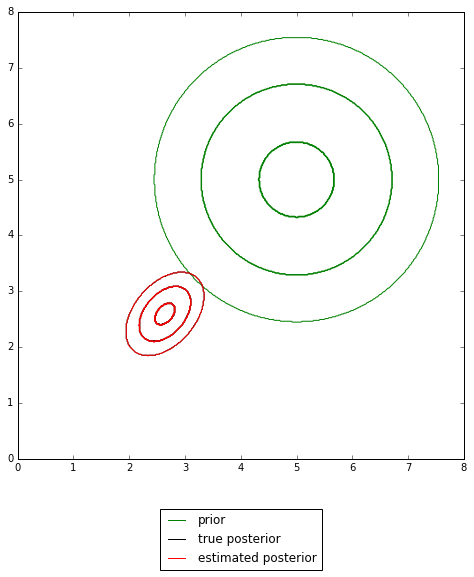

In [57]:
# visualize results if 2D
if len(pred.xs[0].m) == 2:
    res = 500
    xlims = (0, 8)
    ylims = xlims

    xaxis = np.linspace(*xlims, res)
    yaxis = np.linspace(*ylims, res)
    x, y = np.meshgrid(xaxis, yaxis)

    xy = np.concatenate([x.reshape([-1, 1]), 
                         y.reshape([-1, 1])], 
                        axis=1)


    levels = [0.8, 0.5, 0.1]

    prior_contour = probs2contours(prior.eval(xy, log=False), levels).reshape(res, res)
    #like_contour = probs2contours(dist1.eval(xy, log=False), levels).reshape(res, res)
    post_contour = probs2contours(post.eval(xy, log=False), levels).reshape(res, res)
    pred_contour = probs2contours(pred.eval(xy, log=False), levels).reshape(res, res)


    plt.figure(figsize=(8, 8))

    plt.contour(x, y, prior_contour, colors=('g'))
    plt.contour(x, y, post_contour, colors=('k'))
    #plt.contour(x, y, like_contour, colors=('b'))
    plt.contour(x, y, pred_contour, colors=('r'))

    green_line = mlines.Line2D([], [], color='g', label='prior')
    #blue_line = mlines.Line2D([], [], color='b', label='first posterior')
    black_line = mlines.Line2D([], [], color='k', label='true posterior')
    red_line = mlines.Line2D([], [], color='r', label='estimated posterior')
    plt.legend(handles=[green_line, black_line, red_line], 
               loc=9, bbox_to_anchor=(0.5, -0.1))

    plt.show()